# Multi-Modal Testing
Daniel Sery

## Setup

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile


from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB3
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
from pathlib import Path
import os
import joblib
import matplotlib.pyplot as plt


## get data

In [11]:
# labeled data
labeled_dataset_url = 'https://dl.dropboxusercontent.com/scl/fi/da5d82ke08xg2hufm80lh/test_google_images_landslides_six.zip?rlkey=zwfgd556w4s849ofqv38cww7n&dl=0?raw=1'

In [12]:
from urllib.parse import urlparse
file_name = os.path.basename(urlparse(labeled_dataset_url).path)
base_name = os.path.splitext(file_name)[0]

In [13]:
dataset_name = base_name
savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
savepath

'/home/dms3gv/.keras/datasets/test_google_images_landslides_six'

In [14]:
data_dir_labeled = tf.keras.utils.get_file(file_name, origin=labeled_dataset_url, extract=True,
                                       #cache_dir = savepath
                                       )
data_dir_labeled = pathlib.Path(data_dir_labeled).with_suffix('')

In [15]:
data_dir_labeled

PosixPath('/home/dms3gv/.keras/datasets/test_google_images_landslides_six')

In [16]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

## preproc size labels

In [22]:
landslides_subdir = data_dir_labeled / 'Google_Earth_Images/landslides'
nonlandslides_subdir = data_dir_labeled / 'Google_Earth_Images/non-landslides'

In [ ]:
from pathlib import Path
import os
import pandas as pd

data_dir_labeled = Path('/home/dms3gv/.keras/datasets/test_google_images_landslides_six')
landslides_subdir = data_dir_labeled / 'Google_Earth_Images/landslides'

# sort choose only nasa_g since consistent, plus use the others for test
prefix = 'nasa_g_'

image_extensions = ['*.jpg', '*.jpeg', '*.png']


data = []

for ext in image_extensions:
    for file_path in landslides_subdir.glob(f'{prefix}*{ext[-4:]}'):
        filename = file_path.name
        # Extract size label assuming it's the 4th element when split by '_'
        name_without_ext = os.path.splitext(filename)[0]
        parts = name_without_ext.split('_')
        size_label = parts[5] if len(parts) > 5 else 'unknown'
        
        data.append({
            'filename': filename,
            'size_label': size_label,
            'filepath': str(file_path),
            'landslide': 1
        })
        
# add non-landslides
for ext in image_extensions:
    pattern = f'{prefix}*{ext[-4:]}'
    for file_path in nonlandslides_subdir.glob(pattern):
        filename = file_path.name
        size_label = 'unknown'  # Since these are non-landslide images
        data.append({
            'filename': filename,
            'size_label': size_label,
            'filepath': str(file_path),
            'landslide': 0  # Label indicating it's NOT a landslide image
        })


df_filtered = pd.DataFrame(data)
df_filtered['landslide'] = df_filtered['landslide'].astype(int) # ensure int



In [24]:
df_filtered

,filename,size_label,filepath,landslide
0,nasa_g_4700m_11454_2019_large.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1
1,nasa_g_4500m_11542_2018_cat_town.jpg,cat,/home/dms3gv/.keras/datasets/test_google_image...,1
2,nasa_g_4600m_14235_2023_large_four.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1
3,nasa_g_2014m_11257_2020_large.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1
4,nasa_g_3900m_2024005_2020_vylg_three.jpg,vylg,/home/dms3gv/.keras/datasets/test_google_image...,1
...,...,...,...,...
153,nasa_g_4700m_9046_2016_vylg_nonL_five_png.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0
154,nasa_g_4150m_5501_2012_vylg_nonL_three.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0
155,nasa_g_3700_9421_2013_large_nonL_two.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0
156,nasa_g_2500m_11256_2018_large.nonL.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0


In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_filtered['size_label_encoded'] = label_encoder.fit_transform(df_filtered['size_label'])

df_filtered


,filename,size_label,filepath,landslide,size_label_encoded
0,nasa_g_4700m_11454_2019_large.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1,1
1,nasa_g_4500m_11542_2018_cat_town.jpg,cat,/home/dms3gv/.keras/datasets/test_google_image...,1,0
2,nasa_g_4600m_14235_2023_large_four.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1,1
3,nasa_g_2014m_11257_2020_large.jpg,large,/home/dms3gv/.keras/datasets/test_google_image...,1,1
4,nasa_g_3900m_2024005_2020_vylg_three.jpg,vylg,/home/dms3gv/.keras/datasets/test_google_image...,1,5
...,...,...,...,...,...
153,nasa_g_4700m_9046_2016_vylg_nonL_five_png.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0,3
154,nasa_g_4150m_5501_2012_vylg_nonL_three.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0,3
155,nasa_g_3700_9421_2013_large_nonL_two.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0,3
156,nasa_g_2500m_11256_2018_large.nonL.jpg,unknown,/home/dms3gv/.keras/datasets/test_google_image...,0,3


In [26]:
# pickle the encoder for prediction later
import joblib

# Save the label encoder
joblib.dump(label_encoder, 'size_label_encoder.pkl')

['size_label_encoder.pkl']

### create dataset

In [27]:
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust if using PNG
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalize to [0,1]
    return image

In [28]:
# Function to process each sample
def process_sample_multimodal(filepath, size_label_encoded, landslide):
    image = load_and_preprocess_image(filepath)
    # Define existence_label based on 'landslide' column
    # existence_label: 1 for landslide images, 0 for non-landslide images
    existence_label = tf.cast(landslide, tf.float32)
    return {
               'image_input': image,
               'size_input': size_label_encoded
           }, {
               'existence_output': existence_label,
               'size_output': size_label_encoded
           }

In [29]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2
SEED = 42

# extract features and labels
filepaths = df_filtered['filepath'].values
size_labels_encoded = df_filtered['size_label_encoded'].values
landslide_labels = df_filtered['landslide'].values

dataset = tf.data.Dataset.from_tensor_slices((filepaths, size_labels_encoded, landslide_labels))
dataset = dataset.shuffle(buffer_size=len(df_filtered), seed=SEED, reshuffle_each_iteration=False)

# Split into training and validation
val_size = int(len(df_filtered) * VALIDATION_SPLIT)
train_size = len(df_filtered) - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Map the processing function
train_dataset = train_dataset.map(process_sample_multimodal, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(process_sample_multimodal, num_parallel_calls=AUTOTUNE)

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for batch in train_dataset.take(1):
    inputs, outputs = batch
    print(inputs['image_input'].shape)        # (batch_size, IMG_SIZE, IMG_SIZE, 3)
    print(inputs['size_input'].shape)         # (batch_size,)
    print(outputs['existence_output'].shape)  # (batch_size,)
    print(outputs['size_output'].shape)       # (batch_size,)


2024-12-09 21:19:36.126158: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(32, 224, 224, 3)
(32,)
(32,)
(32,)


2024-12-09 21:19:36.668908: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### balance

In [30]:
# Compute class weights for size classification
class_weights_size = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(size_labels_encoded),
    y=size_labels_encoded
)

class_weights_size_dict = {i: weight for i, weight in enumerate(class_weights_size)}

print(class_weights_size_dict)


{0: 2.393939393939394, 1: 0.9753086419753086, 2: 26.333333333333332, 3: 0.32916666666666666, 4: 8.777777777777779, 5: 0.7314814814814815}


## build model

In [36]:
def build_multimodal_model(num_classes_size, learn_rate_land, IMG_SIZE=224):


    # ---------------------------
    # Image Processing Branch
    # ---------------------------

    # Image Input
    image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')

    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name='data_augmentation')
    augmented = data_augmentation(image_input)

    # Pre-trained EfficientNetB3 without top layers
    base_model = EfficientNetB3(include_top=False, input_tensor=augmented, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    # Dropout for regularization
    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # ---------------------------
    # Categorical Label Branch
    # ---------------------------

    # Size Label Input (integer encoded)
    size_input = layers.Input(shape=(1,), name='size_input')  # Shape: (batch_size, 1)

    # Embedding Layer for Size Labels
    embedding_dim = 8  # Dimension of the embedding space
    embedding = layers.Embedding(input_dim=num_classes_size, output_dim=embedding_dim, input_length=1)(size_input)
    embedding = layers.Flatten()(embedding)  # Shape: (batch_size, embedding_dim)

    # Dense Layer for Embedding Features
    y = layers.Dense(16, activation='relu')(embedding)

    # ---------------------------
    # Fusion and Output Layers
    # ---------------------------

    # Concatenate Image and Size Features
    combined = layers.Concatenate()([x, y])

    # Additional Dense Layers for Combined Features
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dense(64, activation='relu')(combined)

    # ---------------------------
    # Output Layers
    # ---------------------------

    # Output for Object Existence (Binary Classification)
    existence_output = layers.Dense(1, activation='sigmoid', name='existence_output')(combined)

    # Output for Size Classification (Categorical Classification)
    size_output = layers.Dense(num_classes_size, activation='softmax', name='size_output')(combined)


    model = models.Model(inputs=[image_input, size_input], outputs=[existence_output, size_output], name="EfficientNet_MultiModal")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learn_rate_land),
        loss={
            'existence_output': 'binary_crossentropy',
            'size_output': 'sparse_categorical_crossentropy'  # Use 'categorical_crossentropy' if labels are one-hot encoded
        },
        metrics={
            'existence_output': ['accuracy'],
            'size_output': ['accuracy']
        }
    )

    return model


In [37]:
num_classes_size = df_filtered['size_label_encoded'].nunique()  # e.g., 4 for 'cat', 'medium', 'large', 'unknown'
learn_rate_land = 1e-4

# build 
model = build_multimodal_model(num_classes_size, learn_rate_land, IMG_SIZE=224)

#model.summary()


/home/dms3gv/.local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [40]:
EPOCHS = 20

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - existence_output_accuracy: 0.4682 - existence_output_loss: 0.7553 - loss: 2.8470 - size_output_accuracy: 0.1077 - size_output_loss: 2.0914 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6780 - val_loss: 2.5741 - val_size_output_accuracy: 0.0000e+00 - val_size_output_loss: 1.8961
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step - existence_output_accuracy: 0.4755 - existence_output_loss: 0.7379 - loss: 2.7066 - size_output_accuracy: 0.1359 - size_output_loss: 1.9691 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6786 - val_loss: 2.5530 - val_size_output_accuracy: 0.0000e+00 - val_size_output_loss: 1.8744
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 930ms/step - existence_output_accuracy: 0.4661 - existence_output_loss: 0.7229 - loss: 2.4785 - size_output_accuracy: 0.2424 - size_output_loss: 1.7554 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6780 - val_loss: 2.5289 - va

In [67]:
results = model.evaluate(val_dataset)


1/1 [==============================] - 0s 127ms/step - loss: 2.3315 - existence_output_loss: 0.6945 - size_output_loss: 1.6371 - existence_output_accuracy: 0.4839 - size_output_accuracy: 0.6129


#### Notes
initial results are not promising

## finetune

### Note
model cant be finetuned using our previous layer unfreezing

In [43]:
# Continue training
history_finetune = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 936ms/step - existence_output_accuracy: 0.5674 - existence_output_loss: 0.7056 - loss: 2.0745 - size_output_accuracy: 0.4629 - size_output_loss: 1.3690 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6852 - val_loss: 2.3659 - val_size_output_accuracy: 0.6129 - val_size_output_loss: 1.6808
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 907ms/step - existence_output_accuracy: 0.6071 - existence_output_loss: 0.6945 - loss: 2.0880 - size_output_accuracy: 0.3930 - size_output_loss: 1.3936 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6861 - val_loss: 2.3649 - val_size_output_accuracy: 0.6129 - val_size_output_loss: 1.6789
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 885ms/step - existence_output_accuracy: 0.5141 - existence_output_loss: 0.7119 - loss: 2.0658 - size_output_accuracy: 0.5078 - size_output_loss: 1.3539 - val_existence_output_accuracy: 0.6129 - val_existence_output_loss: 0.6866 - val_loss: 2.3643 - val_size_ou

In [44]:
# Evaluate the model on the validation set
results = model.evaluate(val_dataset)
print(f"Existence Loss: {results[1]:.4f}, Existence Accuracy: {results[2]:.4f}")
print(f"Size Loss: {results[3]:.4f}, Size Accuracy: {results[4]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - existence_output_accuracy: 0.6129 - existence_output_loss: 0.6866 - loss: 2.3643 - size_output_accuracy: 0.6129 - size_output_loss: 1.6777
Existence Loss: 0.6866, Existence Accuracy: 1.6777
Size Loss: 0.6129, Size Accuracy: 0.6129


## predict

In [45]:
# Load the saved label encoder
size_label_encoder = joblib.load('size_label_encoder.pkl')

# Function to extract the size label from the filename
def extract_size_label(filename):
    # Remove the file extension
    name_without_ext = os.path.splitext(filename)[0]
    # Split by underscores
    parts = name_without_ext.split('_')
    # Assuming size label is the 4th element (index 3)
    if len(parts) > 3:
        return parts[3]
    else:
        return 'unknown'  # Handle cases where the structure is different

# Function to load and preprocess a single image
def load_and_preprocess_image_single(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust if using PNG
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to make a prediction on a single image
def predict_image(image_path, size_label_encoder, model, IMG_SIZE=224):
    # Extract size label from filename
    filename = os.path.basename(image_path)
    size_label = extract_size_label(filename)

    # Encode the size label
    if size_label in size_label_encoder.classes_:
        size_label_encoded = size_label_encoder.transform([size_label])[0]
    else:
        size_label_encoded = size_label_encoder.transform(['unknown'])[0]

    # Preprocess the image
    image = load_and_preprocess_image_single(image_path)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    # Prepare inputs
    inputs = {
        'image_input': image,
        'size_input': tf.constant([[size_label_encoded]])
    }

    # Make prediction
    existence_pred, size_pred = model.predict(inputs)

    # Interpret predictions
    existence = 'Exists' if existence_pred[0][0] > 0.5 else 'Does not exist'
    predicted_size = size_label_encoder.inverse_transform([np.argmax(size_pred)])[0]

    return existence, predicted_size


In [50]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(500,500)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

In [48]:
test_images = [
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_10521_NonSlide.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_11454_NonSlide.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_13710_NonSlide.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_14445_NonSlide.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_Arc_8334_vylg.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_GoogE_10521_large.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_GoogE_11540_cat.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_GoogE_13710_2020_cat.jpg',
    '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_GoogE_14445_cat.jpg'
]

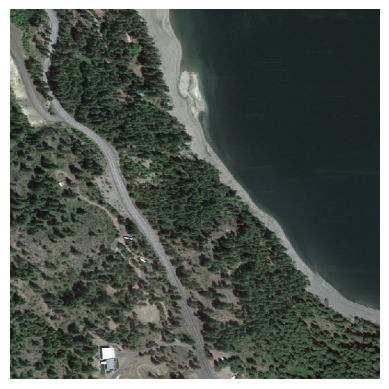

In [53]:
resize_show(test_images[0])

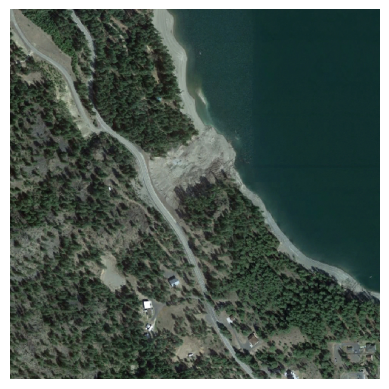

In [52]:
resize_show(test_images[6])

In [47]:
# Example image path (landslide)
new_image_path_landslide = '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg'

# Example image path (non-landslide)
new_image_path_nonlandslide = '/home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_10521_NonSlide.jpg'

# Make predictions
existence_landslide, predicted_size_landslide = predict_image(new_image_path_landslide, size_label_encoder, model, IMG_SIZE=224)
existence_nonlandslide, predicted_size_nonlandslide = predict_image(new_image_path_nonlandslide, size_label_encoder, model, IMG_SIZE=224)

print(f"Image: {new_image_path_landslide}")
print(f" - Object Existence: {existence_landslide}")
print(f" - Predicted Size: {predicted_size_landslide}")

print(f"\nImage: {new_image_path_nonlandslide}")
print(f" - Object Existence: {existence_nonlandslide}")
print(f" - Predicted Size: {predicted_size_nonlandslide}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Image: /home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/landslides/NASA_Arc_6038_vylg.jpg
 - Object Existence: Does not exist
 - Predicted Size: unknown

Image: /home/dms3gv/.keras/datasets/test_google_images_landslides_six/Google_Earth_Images/non-landslides/NASA_GoogE_10521_NonSlide.jpg
 - Object Existence: Does not exist
 - Predicted Size: unknown


In [49]:
# Function to make batch predictions
def predict_batch_images(image_paths, size_label_encoder, model, IMG_SIZE=224):
    images = []
    size_labels_encoded = []
    filenames = []
    
    for path in image_paths:
        filename = os.path.basename(path)
        size_label = extract_size_label(filename)
        
        # Encode the size label
        if size_label in size_label_encoder.classes_:
            size_label_encoded = size_label_encoder.transform([size_label])[0]
        else:
            size_label_encoded = size_label_encoder.transform(['unknown'])[0]
        
        # Preprocess the image
        image = load_and_preprocess_image_single(path)
        images.append(image)
        size_labels_encoded.append(size_label_encoded)
        filenames.append(filename)
    
    # Stack images into a batch
    images = tf.stack(images, axis=0)
    size_inputs = tf.constant(size_labels_encoded, dtype=tf.int32)
    size_inputs = tf.expand_dims(size_inputs, axis=1)  # Shape: (batch_size, 1)
    
    # Prepare inputs
    inputs = {
        'image_input': images,
        'size_input': size_inputs
    }
    
    # Make predictions
    existence_preds, size_preds = model.predict(inputs)
    
    # Interpret predictions
    existence_labels = ['Exists' if prob > 0.5 else 'Does not exist' for prob in existence_preds.flatten()]
    predicted_sizes = size_label_encoder.inverse_transform([np.argmax(pred) for pred in size_preds])
    
    # Compile results
    results = pd.DataFrame({
        'filename': filenames,
        'object_existence': existence_labels,
        'predicted_size': predicted_sizes
    })
    
    return results

# Example usage
batch_results = predict_batch_images(test_images, size_label_encoder, model, IMG_SIZE=224)
print(batch_results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                        filename object_existence predicted_size
0  NASA_GoogE_10521_NonSlide.jpg   Does not exist        unknown
1  NASA_GoogE_11454_NonSlide.jpg   Does not exist        unknown
2  NASA_GoogE_13710_NonSlide.jpg   Does not exist        unknown
3  NASA_GoogE_14445_NonSlide.jpg   Does not exist        unknown
4         NASA_Arc_6038_vylg.jpg   Does not exist        unknown
5         NASA_Arc_8334_vylg.jpg   Does not exist        unknown
6     NASA_GoogE_10521_large.jpg   Does not exist        unknown
7       NASA_GoogE_11540_cat.jpg   Does not exist        unknown
8  NASA_GoogE_13710_2020_cat.jpg   Does not exist        unknown
9       NASA_GoogE_14445_cat.jpg   Does not exist        unknown
